<a href="https://colab.research.google.com/github/shreyasrajesh0308/NNDL-proj/blob/main/Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Necessary Dependencies

In [191]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Conv3D, MaxPooling3D, Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, LSTM, Input, TimeDistributed, Permute, Reshape, MaxPooling2D, GRU
from keras import initializers, Model, optimizers, callbacks
from keras import Sequential
from keras import backend as K
from keras.models import load_model
from keras.callbacks import Callback
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

### Load Data 

Load preprocessed data from Google Drive

In [192]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
X_test = np.load("/content/drive/MyDrive/eeg_project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/eeg_project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/eeg_project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/eeg_project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/eeg_project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/eeg_project/person_test.npy")

Observing some basic characteristics about the data, like shape and output classes

In [194]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [195]:
print(np.unique(y_train_valid))
print(np.unique(y_test))

[769 770 771 772]
[769 770 771 772]


Preprocess test data to convert it to classes in range 0-3

In [196]:
num_classes = 4
y_train_valid = y_train_valid-769
y_test = y_test-769

## Split Data into train and Valid

In [197]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [198]:
print ('Training data shape: {}'.format(X_train.shape))
print ('Valid data shape: {}'.format(X_valid.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Valid target shape: {}'.format(y_valid.shape))

Training data shape: (1692, 22, 1000)
Valid data shape: (423, 22, 1000)
Training target shape: (1692,)
Valid target shape: (423,)


#Data Preprocessing and Augmentation
Here we perform data preprocessing by first trimming the data down and reducing the number of time stamps through a combination of epoch extraction (discarding last 500 samples) and max pool to reduce it from 1000 to 250 time stamps.
We also subsampling of the data, and add in some noise to enhance the size of the training dataset

In [199]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_prep,y_train_prep= data_prep(X_train,y_train,2,2,True)


Shape of X after trimming: (1692, 22, 500)
Shape of X after maxpooling: (1692, 22, 250)
Shape of X after averaging+noise and concatenating: (3384, 22, 250)
Shape of X after subsampling and concatenating: (6768, 22, 250)


In [200]:
def data_prep_test(X,y, sub_sample=2):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X,total_y


X_test,y_test = data_prep_test(X_test, y_test,2)


Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


In [201]:
X_valid_prep,y_valid_prep = data_prep_test(X_valid, y_valid,2)


Shape of X after trimming: (423, 22, 500)
Shape of X after maxpooling: (423, 22, 250)


#Creating Spatial Mesh
We now convert the 2D set of time stamps (22x250) to a 3D 6x7 mesh (6x7x250) to model the relative proximity of the location of the electrodes on the scalp


In [202]:
def spatial_prep(X):
  X = np.swapaxes(X, 0, 1)

  sh = (X.shape[1],X.shape[2])
  new_X = np.array([[np.zeros(sh), np.zeros(sh), np.zeros(sh), X[0,:,:], np.zeros(sh), np.zeros(sh), np.zeros(sh)],
                [np.zeros(sh), X[1,:,:], X[2,:,:], X[3,:,:], X[4,:,:], X[5,:,:], np.zeros(sh)],
                [X[6,:,:],X[7,:,:],X[8,:,:],X[9,:,:],X[10,:,:],X[11,:,:],X[12,:,:]],
                [np.zeros(sh), X[13,:,:],X[14,:,:],X[15,:,:],X[16,:,:],X[17,:,:], np.zeros(sh)],
                [np.zeros(sh), np.zeros(sh), X[18,:,:],X[19,:,:],X[20,:,:], np.zeros(sh), np.zeros(sh)],
                [np.zeros(sh), np.zeros(sh), np.zeros(sh), X[21,:,:], np.zeros(sh), np.zeros(sh), np.zeros(sh)]])

  
  new_X = np.swapaxes(new_X, 0,2)
  new_X = np.swapaxes(new_X, 1,2)
  return new_X

In [203]:
X_spatial_train = spatial_prep(X_train_prep)

In [204]:
X_spatial_val = spatial_prep(X_valid_prep)

In [205]:
X_spatial_test = spatial_prep(X_test)

In [206]:
print(X_spatial_train.shape, X_spatial_val.shape, X_spatial_test.shape)

(6768, 6, 7, 250) (423, 6, 7, 250) (443, 6, 7, 250)


We now convert the labels to one hot encoded vectors

In [207]:

y_train_prep = keras.utils.to_categorical(y_train_prep, num_classes)
y_valid_prep = keras.utils.to_categorical(y_valid_prep, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [208]:
print(X_train_prep.shape,y_train_prep.shape, X_spatial_train.shape)
print(X_valid_prep.shape,y_valid_prep.shape, X_spatial_val.shape)
print(X_test.shape, y_test.shape, X_spatial_test.shape)

(6768, 22, 250) (6768, 4) (6768, 6, 7, 250)
(423, 22, 250) (423, 4) (423, 6, 7, 250)
(443, 22, 250) (443, 4) (443, 6, 7, 250)


To streamline the input into the model, we also swap the axis of the input data to make the 3D convolution of the mesh easier

In [209]:
X_spatial_train = np.swapaxes(X_spatial_train , 1,3)
X_spatial_train = np.swapaxes(X_spatial_train , 2,3)
X_spatial_val = np.swapaxes(X_spatial_val , 1,3)
X_spatial_val = np.swapaxes(X_spatial_val , 2,3)
X_spatial_test  = np.swapaxes(X_spatial_test , 1,3)
X_spatial_test = np.swapaxes(X_spatial_test , 2,3)

In [210]:
print(X_train_prep.shape,y_train_prep.shape, X_spatial_train.shape)
print(X_valid_prep.shape,y_valid_prep.shape, X_spatial_val.shape)
print(X_test.shape, y_test.shape, X_spatial_test.shape)

(6768, 22, 250) (6768, 4) (6768, 250, 6, 7)
(423, 22, 250) (423, 4) (423, 250, 6, 7)
(443, 22, 250) (443, 4) (443, 250, 6, 7)


## 3D conv + GRU with all subjects

We now define the model architecture to be used for the task, and subsequently train it and test its accuracy. We also use this section to perform hyperparamater tuning and architecture selection to arrive that the model that performs best on this task.

In [264]:
lecun = initializers.lecun_normal(seed=42)

model = Sequential()

model.add(Reshape((250, 6, 7, 1), input_shape = (250,6,7)))

model.add(Conv3D(filters=25, kernel_size=(10,1,1), kernel_initializer = lecun, strides=1, data_format="channels_last"))
model.add(Conv3D(filters=25, kernel_size=(1,6,7), kernel_initializer = lecun ))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling3D(pool_size = (3,1,1), strides = (3,1,1)))
model.add(Dropout(0.5))

# Conv Pool Block 2
model.add(Conv3D(filters = 50, kernel_size = (10,1,1), activation = 'elu', kernel_initializer = lecun))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling3D(pool_size = (3,1,1), strides = (3,1,1)))
model.add(Dropout(0.5))

model.add(Permute((1, 4, 3, 2)))
model.add(Reshape((23, 50)))

# GRU layers
model.add(GRU(16, return_sequences=True))
model.add(GRU(16, return_sequences=True))
model.add(Dropout(0.5))

# Dense layers
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_22 (Reshape)        (None, 250, 6, 7, 1)      0         
                                                                 
 conv3d_33 (Conv3D)          (None, 241, 6, 7, 25)     275       
                                                                 
 conv3d_34 (Conv3D)          (None, 241, 1, 1, 25)     26275     
                                                                 
 batch_normalization_22 (Bat  (None, 241, 1, 1, 25)    100       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 241, 1, 1, 25)     0         
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 80, 1, 1, 25)     0         
 g3D)                                                

In [212]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_spatial_train, y_train_prep, batch_size=64, epochs=200,
                    validation_data=(X_spatial_val, y_valid_prep))

Epoch 1/200
106/106 [==============================] - 109s 26ms/step - loss: 1.4067 - acc: 0.2881 - val_loss: 1.3143 - val_acc: 0.3664
Epoch 2/200
106/106 [==============================] - 1s 14ms/step - loss: 1.2927 - acc: 0.3907 - val_loss: 1.2531 - val_acc: 0.4161
Epoch 3/200
106/106 [==============================] - 1s 14ms/step - loss: 1.2260 - acc: 0.4350 - val_loss: 1.2264 - val_acc: 0.4468
Epoch 4/200
106/106 [==============================] - 1s 14ms/step - loss: 1.1860 - acc: 0.4638 - val_loss: 1.1838 - val_acc: 0.4610
Epoch 5/200
106/106 [==============================] - 1s 14ms/step - loss: 1.1305 - acc: 0.5163 - val_loss: 1.1844 - val_acc: 0.4941
Epoch 6/200
106/106 [==============================] - 1s 14ms/step - loss: 1.0809 - acc: 0.5312 - val_loss: 1.0873 - val_acc: 0.5437
Epoch 7/200
106/106 [==============================] - 1s 14ms/step - loss: 1.0366 - acc: 0.5669 - val_loss: 1.0691 - val_acc: 0.5366
Epoch 8/200
106/106 [==============================] - 1s 14

In [213]:

test_loss, test_acc = model.evaluate(X_spatial_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


14/14 [==============================] - 0s 6ms/step - loss: 0.9697 - acc: 0.7201
Test accuracy 0.7200902700424194
Test loss 0.969683825969696


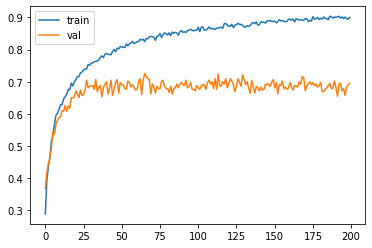

In [214]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend();

## Training the model on entire data
We now train the optimised model from the previous section on the data on the entire data, i.e both train and val sets. Note: we have also saved the architecture of the model as a SavedModel file from Colab, and are including it along with the submission

In [215]:
X_train_all,y_train_all= data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [216]:
X_spatial_all = spatial_prep(X_train_all)

In [217]:
y_train_all = keras.utils.to_categorical(y_train_all, num_classes)

In [218]:
X_spatial_all = np.swapaxes(X_spatial_all,1,3)
X_spatial_all = np.swapaxes(X_spatial_all,2,3)

In [219]:
print(X_spatial_all.shape, y_train_all.shape, y_test.shape, X_spatial_test.shape)

(8460, 250, 6, 7) (8460, 4) (443, 4) (443, 250, 6, 7)


In [265]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [266]:
callbacks = keras.callbacks.ReduceLROnPlateau(
  monitor='loss', factor=0.1, patience=10,
  mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)

In [230]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
history = model.fit(X_spatial_all, y_train_all, batch_size=64, epochs=200, callbacks = callbacks)

Epoch 1/200
133/133 [==============================] - 5s 14ms/step - loss: 1.3841 - acc: 0.3191 - lr: 0.0010
Epoch 2/200
133/133 [==============================] - 2s 13ms/step - loss: 1.2639 - acc: 0.4071 - lr: 0.0010
Epoch 3/200
133/133 [==============================] - 2s 13ms/step - loss: 1.1880 - acc: 0.4730 - lr: 0.0010
Epoch 4/200
133/133 [==============================] - 2s 13ms/step - loss: 1.1351 - acc: 0.5129 - lr: 0.0010
Epoch 5/200
133/133 [==============================] - 2s 13ms/step - loss: 1.0891 - acc: 0.5320 - lr: 0.0010
Epoch 6/200
133/133 [==============================] - 2s 13ms/step - loss: 1.0515 - acc: 0.5557 - lr: 0.0010
Epoch 7/200
133/133 [==============================] - 2s 13ms/step - loss: 1.0274 - acc: 0.5735 - lr: 0.0010
Epoch 8/200
133/133 [==============================] - 2s 13ms/step - loss: 0.9866 - acc: 0.5907 - lr: 0.0010
Epoch 9/200
133/133 [==============================] - 2s 13ms/step - loss: 0.9444 - acc: 0.6147 - lr: 0.0010
Epoch 10/2

In [290]:
# giga = keras.models.load_model('final-model')
# model = giga
test_loss, test_acc = model.evaluate(X_spatial_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

14/14 [==============================] - 0s 7ms/step - loss: 0.8571 - acc: 0.7698
Test accuracy 0.7697516679763794
Test loss 0.8571227788925171



To assess how the model performed on different classes, we plot a confusion matrix to compute class performance

In [291]:
y_pred = model.predict(X_spatial_test)

In [292]:
print(y_pred.shape)

(443, 4)


In [293]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 

In [294]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

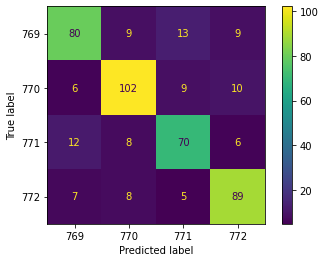

In [295]:
log_disp = ConfusionMatrixDisplay(matrix, display_labels=[769, 770, 771, 772]) 
log_disp.plot()

In [296]:
model.save('final-model')

INFO:tensorflow:Assets written to: final-model/assets


INFO:tensorflow:Assets written to: final-model/assets


In [297]:
for j in range(9):
  indeces = [ i for i in range(len(person_test)) if person_test[i]==j]
  X_subject= X_test[indeces]
  y_subject = y_test[indeces]
  X_spatial_subject = spatial_prep(X_subject)
  X_spatial_subject = np.swapaxes(X_spatial_subject, 1,3)
  X_spatial_subject = np.swapaxes(X_spatial_subject, 2,3)

  test_loss_subject, test_acc_subject = model.evaluate(X_spatial_subject, y_subject)
  print("Statistics for subject ", j)
  print("Test accuracy", test_acc_subject)
  print("Test loss", test_loss_subject)

2/2 [==============================] - 0s 9ms/step - loss: 1.1200 - acc: 0.6800
Statistics for subject  0
Test accuracy 0.6800000071525574
Test loss 1.1200186014175415
2/2 [==============================] - 0s 9ms/step - loss: 0.7176 - acc: 0.7800
Statistics for subject  1
Test accuracy 0.7799999713897705
Test loss 0.7175740599632263
2/2 [==============================] - 0s 9ms/step - loss: 0.7058 - acc: 0.8000
Statistics for subject  2
Test accuracy 0.800000011920929
Test loss 0.7058024406433105
2/2 [==============================] - 0s 9ms/step - loss: 0.8001 - acc: 0.7600
Statistics for subject  3
Test accuracy 0.7599999904632568
Test loss 0.800101637840271
2/2 [==============================] - 0s 8ms/step - loss: 1.1086 - acc: 0.7021
Statistics for subject  4
Test accuracy 0.7021276354789734
Test loss 1.1085593700408936
2/2 [==============================] - 0s 9ms/step - loss: 0.8561 - acc: 0.7551
Statistics for subject  5
Test accuracy 0.7551020383834839
Test loss 0.85613888502

#Training the model for one subject
We now train the model architecture on just one subject, and compute the test accuracies for both the subject in question, and for all subjects

In [244]:
train_indeces = [ i for i in range(len(person_train_valid)) if person_train_valid[i]==0]
X_train_subject_1 = X_train_valid[train_indeces]
y_train_subject_1 = y_train_valid[train_indeces]

In [245]:
test_indeces = [ i for i in range(len(person_test)) if person_test[i]==0]
X_test_subject_1 = X_test[test_indeces]
y_test_subject_1 = y_test[test_indeces]


In [246]:
print(X_train_subject_1.shape, y_train_subject_1.shape, X_test_subject_1.shape, y_test_subject_1.shape)

(237, 22, 1000) (237,) (50, 22, 250) (50, 4)


In [247]:
X_train_1,y_train_1= data_prep(X_train_subject_1,y_train_subject_1,2,2,True)

Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)


In [248]:
X_spatial_train_1 = spatial_prep(X_train_1)

In [249]:
X_spatial_test_1 = spatial_prep(X_test_subject_1)

In [250]:
print(X_spatial_train_1.shape,X_spatial_test_1.shape)

(948, 6, 7, 250) (50, 6, 7, 250)


In [251]:
print(X_train_1.shape,y_train_1.shape, X_spatial_train_1.shape)
print(X_test_subject_1.shape, y_test_subject_1.shape, X_spatial_test_1.shape)

(948, 22, 250) (948,) (948, 6, 7, 250)
(50, 22, 250) (50, 4) (50, 6, 7, 250)


In [252]:
X_spatial_train_1 = np.swapaxes(X_spatial_train_1 , 1,3)
X_spatial_train_1 = np.swapaxes(X_spatial_train_1 , 2,3)
X_spatial_test_1  = np.swapaxes(X_spatial_test_1, 1,3)
X_spatial_test_1 = np.swapaxes(X_spatial_test_1 , 2,3)

In [256]:
y_train_1 = keras.utils.to_categorical(y_train_1, num_classes)

In [257]:
print(X_train_1.shape,y_train_1.shape, X_spatial_train_1.shape)
print(X_test_subject_1.shape, y_test_subject_1.shape, X_spatial_test_1.shape)

(948, 22, 250) (948, 4) (948, 250, 6, 7)
(50, 22, 250) (50, 4) (50, 250, 6, 7)


In [267]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
history = model.fit(X_spatial_train_1, y_train_1, batch_size=64, epochs=100, callbacks = callbacks)

Epoch 1/100
15/15 [==============================] - 3s 20ms/step - loss: 1.4719 - acc: 0.2416 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 1.3926 - acc: 0.3312 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 1.3768 - acc: 0.3186 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 1.3434 - acc: 0.3576 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 1.2801 - acc: 0.4177 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 1.2427 - acc: 0.4325 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 1.1909 - acc: 0.4747 - lr: 0.0010
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 1.1651 - acc: 0.4916 - lr: 0.0010
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0964 - acc: 0.5158 - lr: 0.0010
Epoch 10/100
15/15 [========

In [268]:
#Test accuracy for Subject 0

test_loss_1, test_acc_1 = model.evaluate(X_spatial_test_1, y_test_subject_1)

print("Test accuracy", test_acc_1)
print("Test loss", test_loss_1)

2/2 [==============================] - 1s 10ms/step - loss: 1.8978 - acc: 0.6000
Test accuracy 0.6000000238418579
Test loss 1.8977808952331543


In [269]:
#Test accuracy across all subjects

test_loss_all, test_acc_all = model.evaluate(X_spatial_test, y_test)

print("Test accuracy", test_acc_all)
print("Test loss", test_loss_all)

14/14 [==============================] - 0s 7ms/step - loss: 3.9685 - acc: 0.3995
Test accuracy 0.3995485305786133
Test loss 3.968545436859131


In [272]:
y_pred_1 = model.predict(X_spatial_test)

In [273]:
matrix_one = confusion_matrix(y_test.argmax(axis=1), y_pred_1.argmax(axis=1))

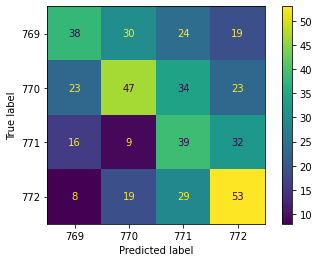

In [275]:
log_disp_one = ConfusionMatrixDisplay(matrix_one, display_labels=[769, 770, 771, 772]) 
log_disp_one.plot()

In [276]:
for j in range(9):
  indeces = [ i for i in range(len(person_test)) if person_test[i]==j]
  X_subject= X_test[indeces]
  y_subject = y_test[indeces]
  X_spatial_subject = spatial_prep(X_subject)
  X_spatial_subject = np.swapaxes(X_spatial_subject, 1,3)
  X_spatial_subject = np.swapaxes(X_spatial_subject, 2,3)

  test_loss_subject, test_acc_subject = model.evaluate(X_spatial_subject, y_subject)
  print("Statistics for subject ", j)
  print("Test accuracy", test_acc_subject)
  print("Test loss", test_loss_subject)

2/2 [==============================] - 0s 7ms/step - loss: 1.8978 - acc: 0.6000
Statistics for subject  0
Test accuracy 0.6000000238418579
Test loss 1.8977808952331543
2/2 [==============================] - 0s 7ms/step - loss: 4.4162 - acc: 0.3400
Statistics for subject  1
Test accuracy 0.3400000035762787
Test loss 4.416205406188965
2/2 [==============================] - 0s 9ms/step - loss: 2.0131 - acc: 0.5600
Statistics for subject  2
Test accuracy 0.5600000023841858
Test loss 2.013089656829834
2/2 [==============================] - 0s 9ms/step - loss: 3.6129 - acc: 0.3800
Statistics for subject  3
Test accuracy 0.3799999952316284
Test loss 3.612865924835205
2/2 [==============================] - 0s 10ms/step - loss: 4.9795 - acc: 0.4043
Statistics for subject  4
Test accuracy 0.40425533056259155
Test loss 4.979465961456299
2/2 [==============================] - 0s 9ms/step - loss: 6.1326 - acc: 0.2653
Statistics for subject  5
Test accuracy 0.26530611515045166
Test loss 6.1325931549